<a href="https://colab.research.google.com/github/Vish212121/Sentiment-Analysis-of-Financial-News-for-Stock-Market/blob/main/Sentiment_Analysis_of_Financial_News_for_Stock_Market_Prediction_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import random
import seaborn as sns
import requests
import zipfile
import os

nltk.download('stopwords')

print("Tensorflow Version", tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...


Tensorflow Version 2.18.0


[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('stock_data.csv', encoding='latin', header=None)
df1 = df.iloc[1:]
df.drop(index=df.index[0], axis=0, inplace=True)
df.columns = ['text', 'sentiment']

# Label decoding
lab_to_sentiment = {"-1": "Negative", "1": "Positive"}
def label_decoder(label):
    y = lab_to_sentiment.get(label)
    if y is not None:
        return y
    else:
        return "Unknown"

df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))

# Display first few rows
df.head()

,text,sentiment
1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,Positive
2,user: AAP MOVIE. 55% return for the FEA/GEED i...,Positive
3,user I'd be afraid to short AMZN - they are lo...,Positive
4,MNTA Over 12.00,Positive
5,OI Over 21.37,Positive


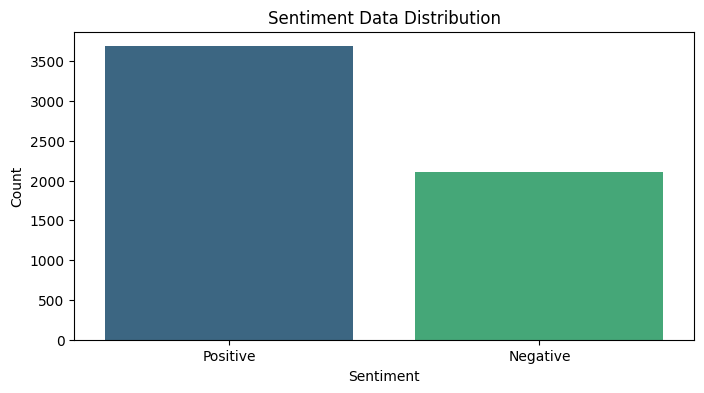

,text,sentiment
3767,INFN at 7,Positive
3917,AAP a classic move to 435 testing on no cause....,Negative
2703,For the past 10 years VFC has booked an avg re...,Positive
242,GOOG with simple Fibonacci projections on clos...,Positive
2676,BAC Vol. Fall on EOD.. Possibly Small Sell-Off !,Negative
5595,IndusInd Bank Crashes 27% From Day's High As T...,Negative
1306,Watch list stocks that triggered as new buys t...,Positive
4823,o-Hi Setups: MNKD DVAX ANAD ATM AZK BEE DANG G...,Positive
4734,"MNKD flagging nicely, like it over 3.39",Positive
4240,CIEN still a good short if it goes under 17.11...,Negative


In [ ]:
val_count = df.sentiment.value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=val_count.index, y=val_count.values, hue=val_count.index, palette="viridis", dodge=False, legend=False)
plt.title("Sentiment Data Distribution")
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Display random samples
random_idx_list = [random.randint(1, len(df.text)) for _ in range(10)]
df.loc[random_idx_list, :].head(10)

In [ ]:
# Define stopwords and stemmer
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Preprocessing function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

# Display first few rows after preprocessing
df.head()

,text,sentiment
1,kickers watchlist xide tit soq pnk cpw bpz aj ...,Positive
2,user aap movie 55 return fea geed indicator 15...,Positive
3,user afraid short amzn looking like near monop...,Positive
4,mnta 12 00,Positive
5,oi 21 37,Positive


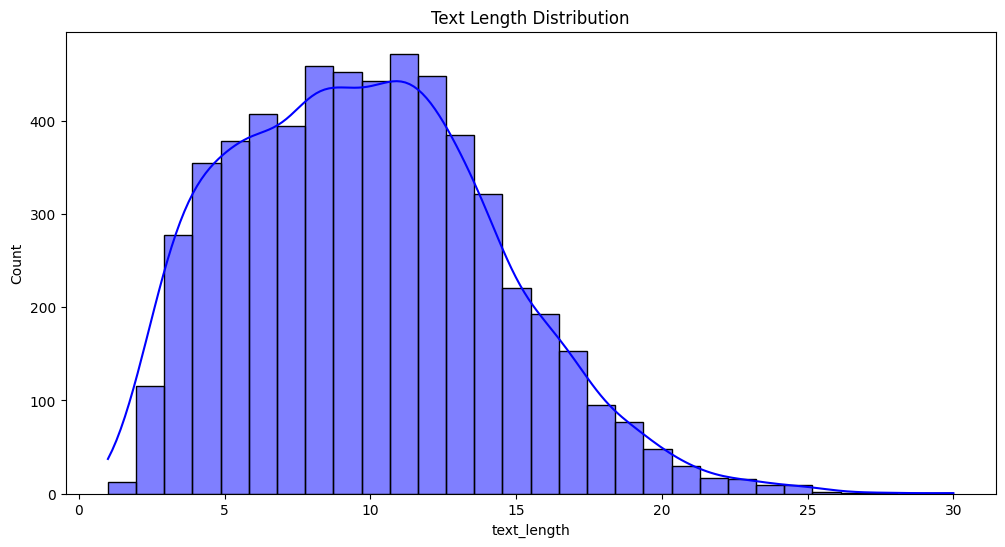

In [ ]:
df['text_length'] = df.text.apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], kde=True, bins=30, color='blue')
plt.title("Text Length Distribution")
plt.show()

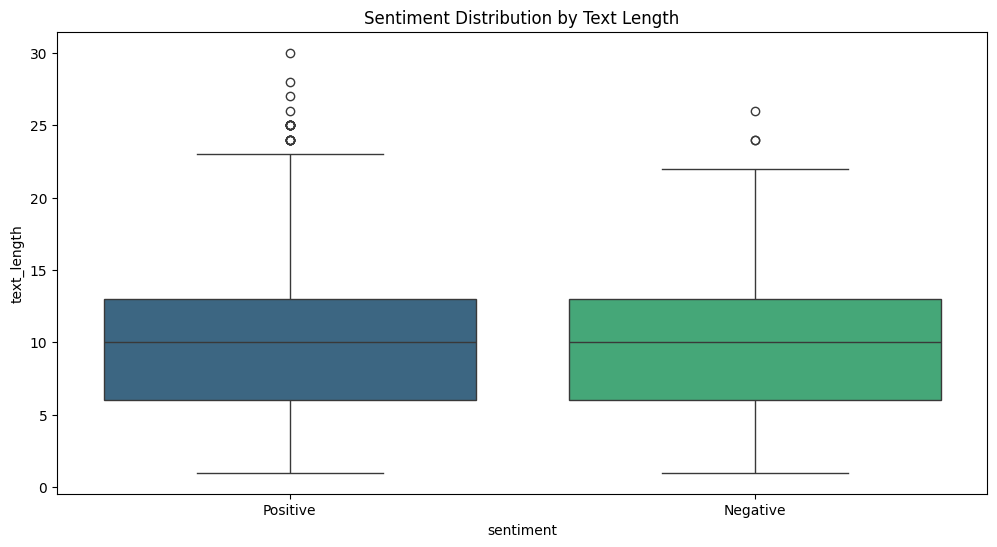

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment', y='text_length', data=df, hue='sentiment', palette="viridis", legend=False)
plt.title("Sentiment Distribution by Text Length")
plt.show()

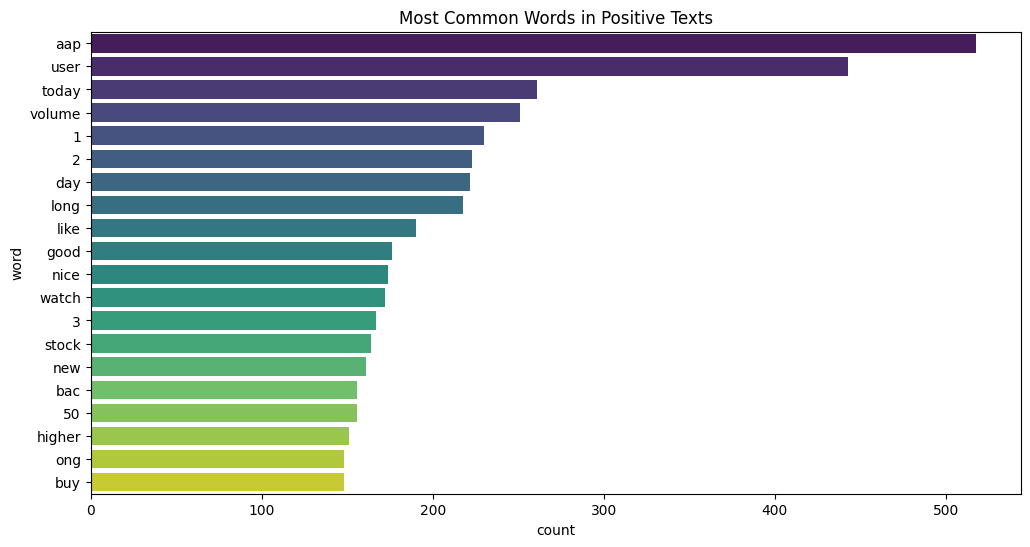

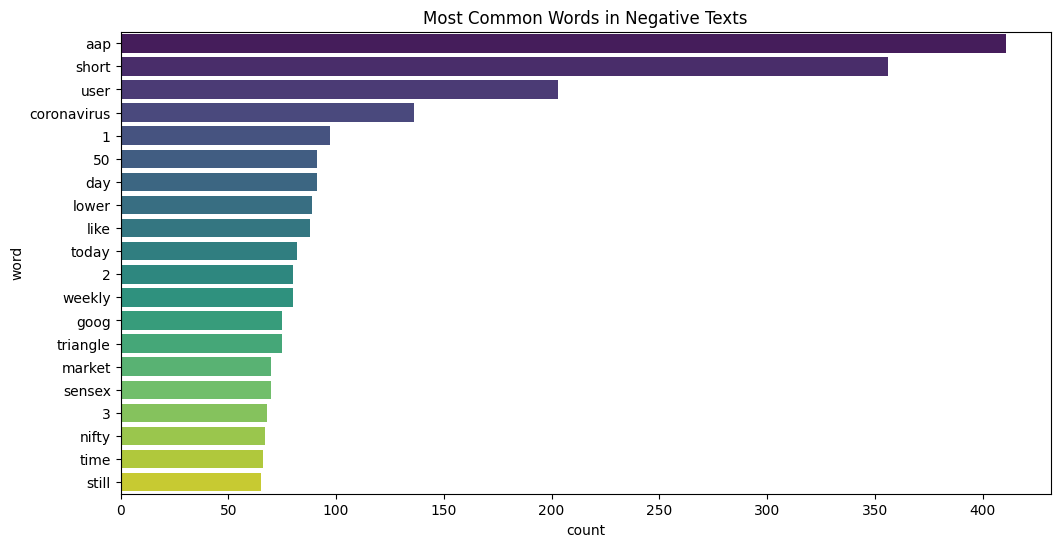

In [ ]:
from collections import Counter

# Function to plot the most common words
def plot_most_common_words(text, sentiment):
    words = ' '.join(text).split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(20)

    df_common_words = pd.DataFrame(common_words, columns=['word', 'count'])

    plt.figure(figsize=(12, 6))
    sns.barplot(x='count', y='word', hue='word', dodge=False, data=df_common_words, palette='viridis', legend=False)
    plt.title(f'Most Common Words in {sentiment} Texts')
    plt.show()

# Plot most common words for positive texts
plot_most_common_words(df[df.sentiment == 'Positive'].text, 'Positive')

# Plot most common words for negative texts
plot_most_common_words(df[df.sentiment == 'Negative'].text, 'Negative')

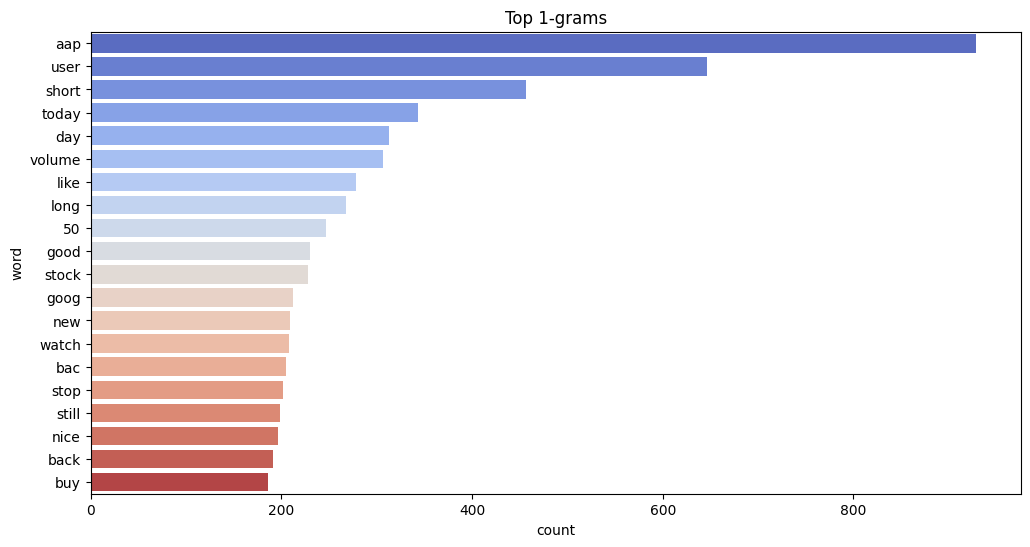

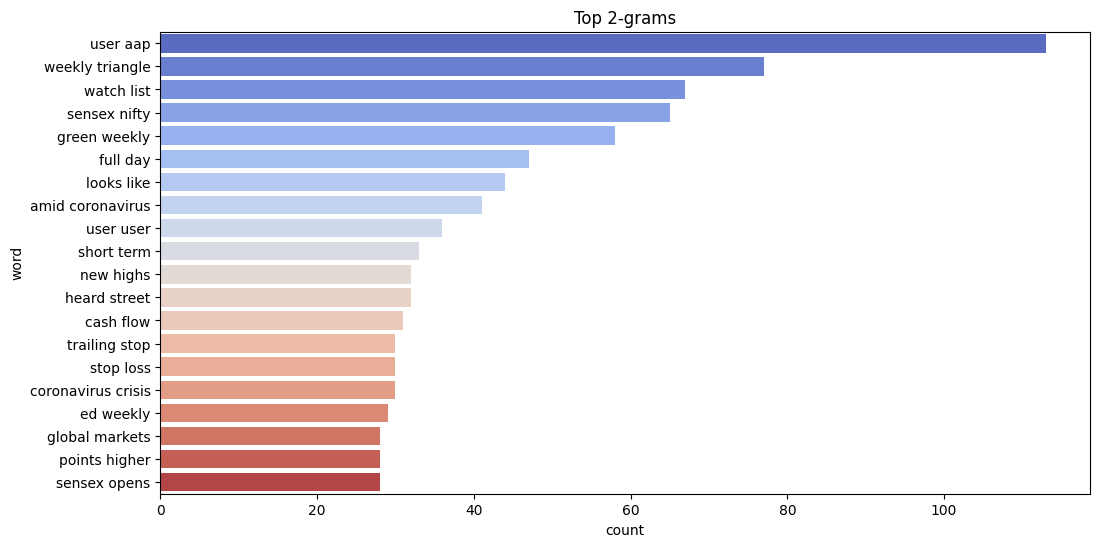

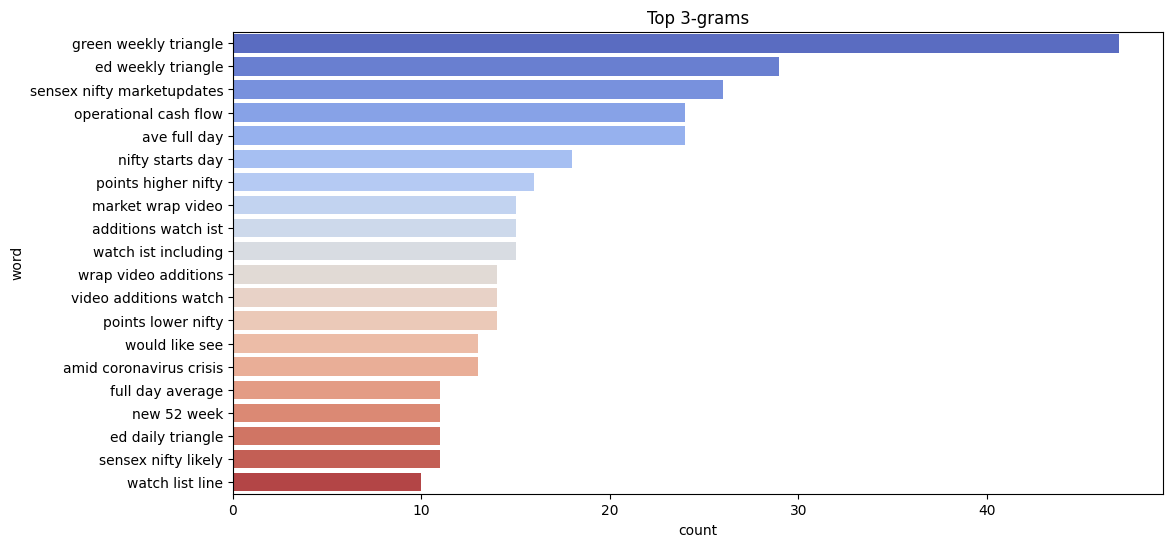

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to plot top n-grams
def plot_top_ngrams(text, n, title):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    df_ngrams = pd.DataFrame(words_freq[:20], columns=['word', 'count'])

    plt.figure(figsize=(12, 6))
    sns.barplot(x='count', y='word', hue='word', dodge=False, data=df_ngrams, palette='coolwarm', legend=False)
    plt.title(f'Top {n}-grams')
    plt.show()

# Plot top unigrams (1-grams)
plot_top_ngrams(df.text, 1, 'Top Unigrams')

# Plot top bigrams (2-grams)
plot_top_ngrams(df.text, 2, 'Top Bigrams')

# Plot top trigrams (3-grams)
plot_top_ngrams(df.text, 3, 'Top Trigrams')

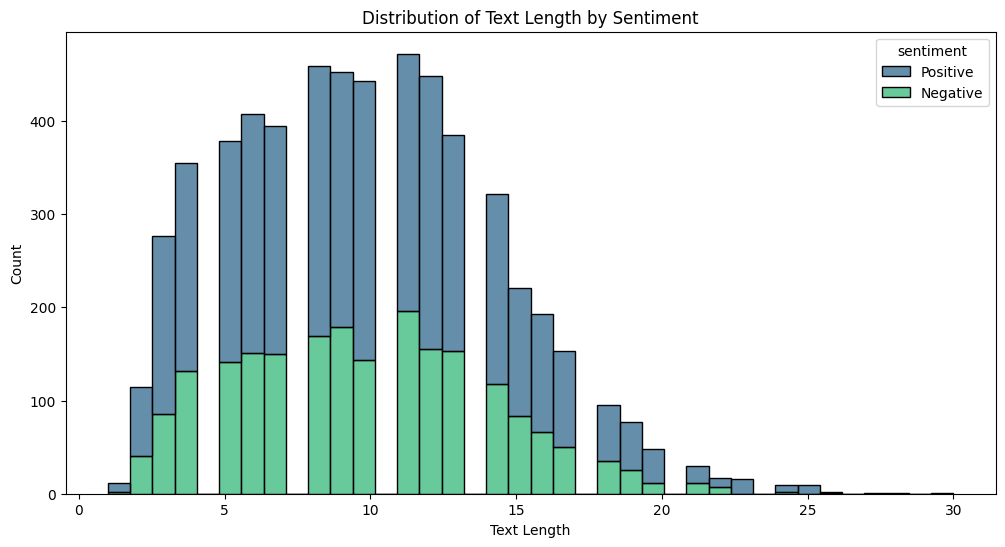

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='sentiment', multiple='stack', palette='viridis')
plt.title('Distribution of Text Length by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

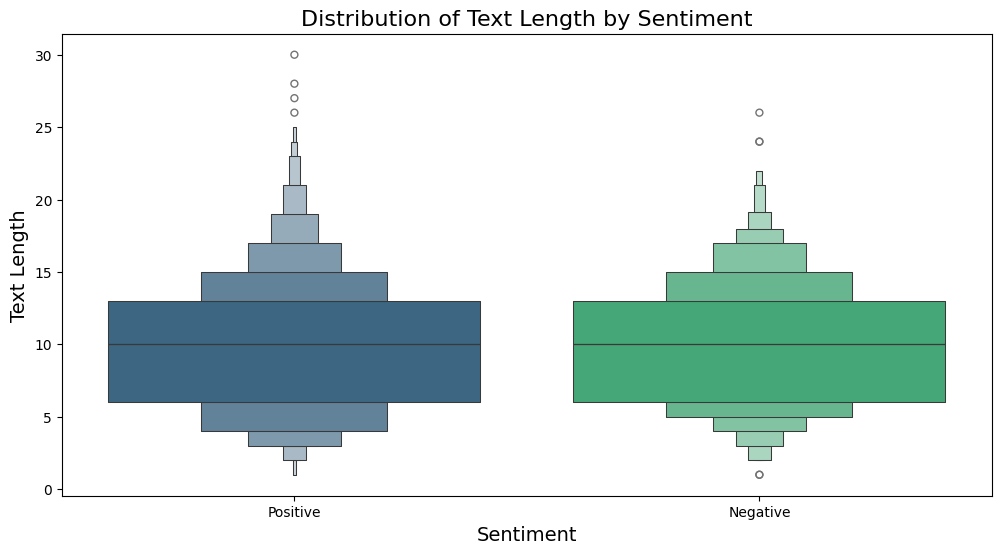

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxenplot(x='sentiment', y='text_length', hue='sentiment', palette='viridis', dodge=False, legend=False, data=df)
plt.title('Distribution of Text Length by Sentiment', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Text Length', fontsize=14)
plt.show()

In [ ]:
TRAIN_SIZE = 0.8
MAX_SEQUENCE_LENGTH = 30

# Split the data
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=7)
print("Train Data size:", len(train_data))
print("Test Data size:", len(test_data))

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size:", vocab_size)

# Pad the sequences
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen=MAX_SEQUENCE_LENGTH)

print("Training X Shape:", x_train.shape)
print("Testing X Shape:", x_test.shape)

# Encode the labels
labels = train_data.sentiment.unique().tolist()
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Train Data size: 4632
Test Data size: 1159
Vocabulary Size: 7947
Training X Shape: (4632, 30)
Testing X Shape: (1159, 30)
y_train shape: (4632, 1)
y_test shape: (1159, 1)


In [ ]:
# Path to save the GloVe zip file
zip_path = os.path.join("Documents", "Deep Learning", "NLP", "stocks", "glove.6B.zip")
extracted_path = os.path.join("Documents", "Deep Learning", "NLP", "stocks")

# URL of the GloVe embeddings
url = "http://nlp.stanford.edu/data/glove.6B.zip"

# Create directories if they don't exist
os.makedirs(extracted_path, exist_ok=True)

# Download the file
response = requests.get(url, stream=True)
with open(zip_path, "wb") as f:
    for chunk in response.iter_content(chunk_size=128):
        f.write(chunk)

# Unzip the file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extracted_path)

# Path to the extracted GloVe file
GLOVE_EMB = os.path.join(extracted_path, "glove.6B.300d.txt")
if not os.path.exists(GLOVE_EMB):
    raise FileNotFoundError(f"File not found: {GLOVE_EMB}")

# Load the GloVe embeddings
embeddings_index = {}

with open(GLOVE_EMB, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# Create the embedding matrix
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create the embedding layer
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            trainable=False)

Found 400000 word vectors.


In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Define additional parameters
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

# Define the model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(factor=0.1, min_lr=0.01, monitor='val_loss', verbose=1)

# Train the model
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[reduce_lr])

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Training on CPU...
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6070 - loss: 0.6752 - val_accuracy: 0.6428 - val_loss: 0.6451 - learning_rate: 0.0010
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 706ms/step - accuracy: 0.6323 - loss: 0.6504 - val_accuracy: 0.6428 - val_loss: 0.6317 - learning_rate: 0.0010
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 879ms/step - accuracy: 0.6363 - loss: 0.6291 - val_accuracy: 0.6549 - val_loss: 0.6082 - learning_rate: 0.0010
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 707ms/step - accuracy: 0.6770 - loss: 0.5934 - val_accuracy: 0.6764 - val_loss: 0.6019 - learning_rate: 0.0010
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 728ms/step - accuracy: 0.7221 - loss: 0.5623 - val_accuracy: 0.6885 - val_loss: 0.5864 - learning_rate: 0.0010
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 802ms/step - accuracy: 0.7374 - loss: 0.5347 - val_accuracy: 0.6885 - val_loss: 0.5763 - learning_rate: 0.0010
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 687ms/step - accuracy: 0.7535 - loss: 0.5125

In [ ]:
# Step 1: Save the trained model
model.save("model.h5")

# Step 2: Save the tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model and tokenizer saved successfully!")


Model and tokenizer saved successfully!


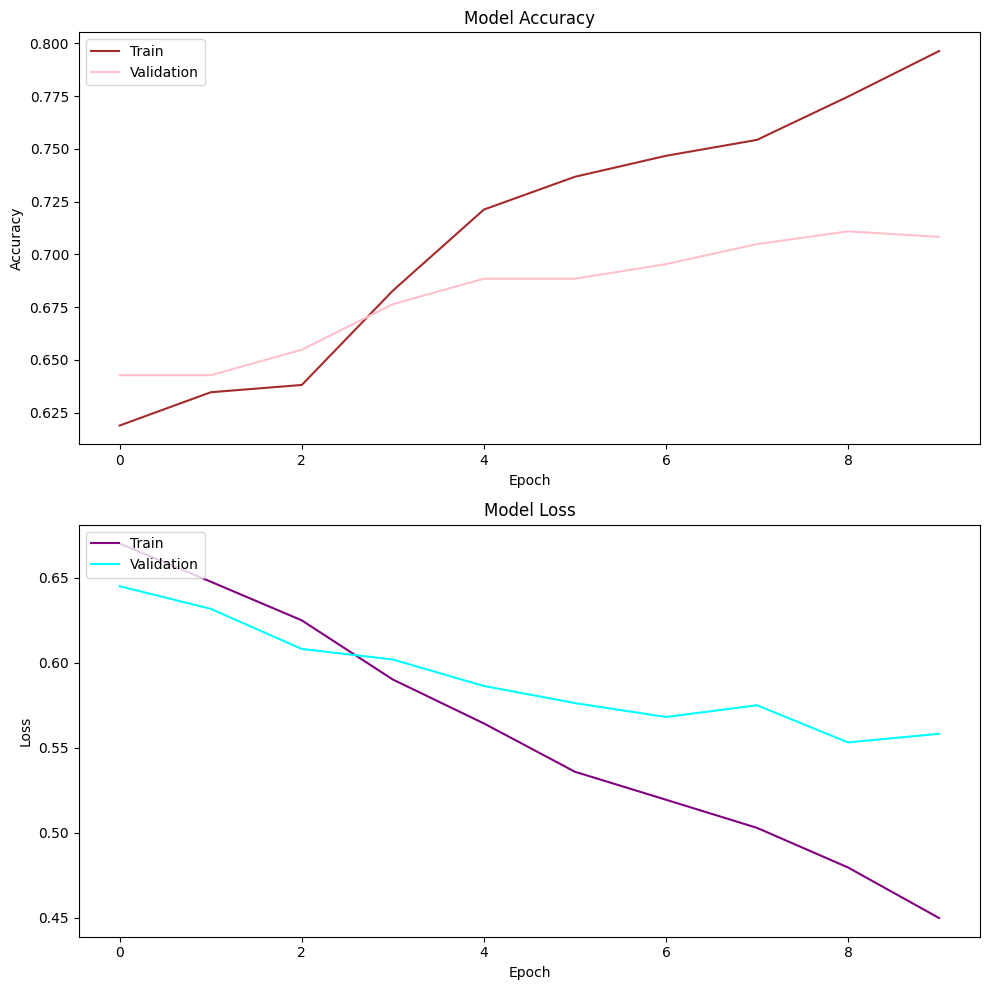

In [ ]:
s, (at, al) = plt.subplots(2, 1, figsize=(10, 10))
at.plot(history.history['accuracy'], c='brown')
at.plot(history.history['val_accuracy'], c='pink')
at.set_title('Model Accuracy')
at.set_ylabel('Accuracy')
at.set_xlabel('Epoch')
at.legend(['Train', 'Validation'], loc='upper left')

al.plot(history.history['loss'], c='purple')
al.plot(history.history['val_loss'], c='cyan')
al.set_title('Model Loss')
al.set_ylabel('Loss')
al.set_xlabel('Epoch')
al.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


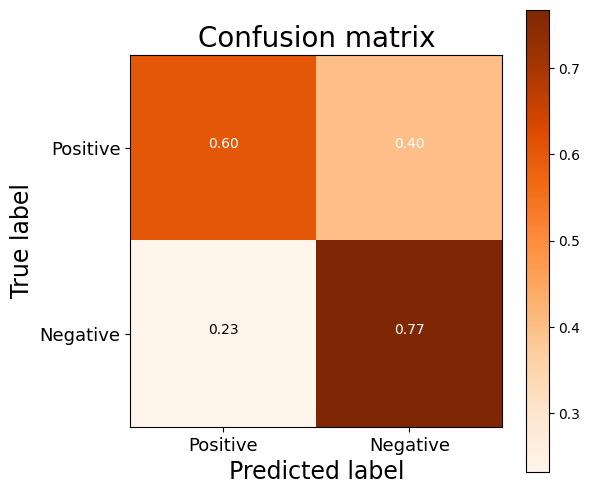

In [ ]:
def decode_sentiment(score):
    return "Positive" if score > 0.5 else "Negative"

# Predict and decode sentiment
scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Oranges):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

# Compute and plot confusion matrix
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

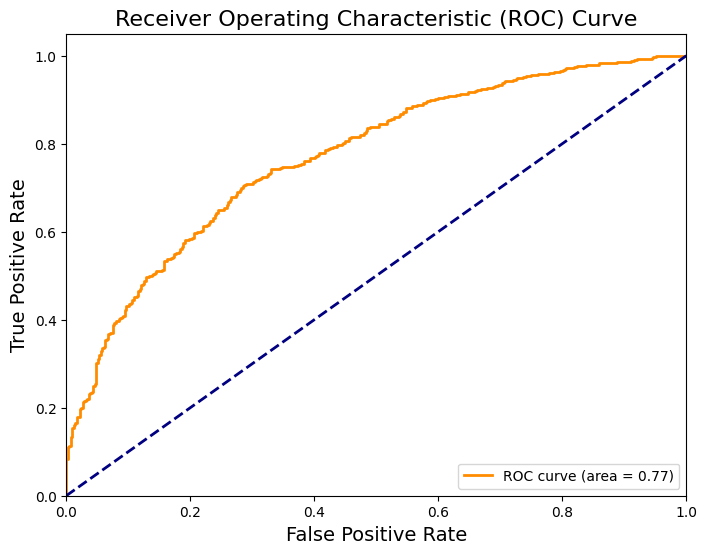

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.show()

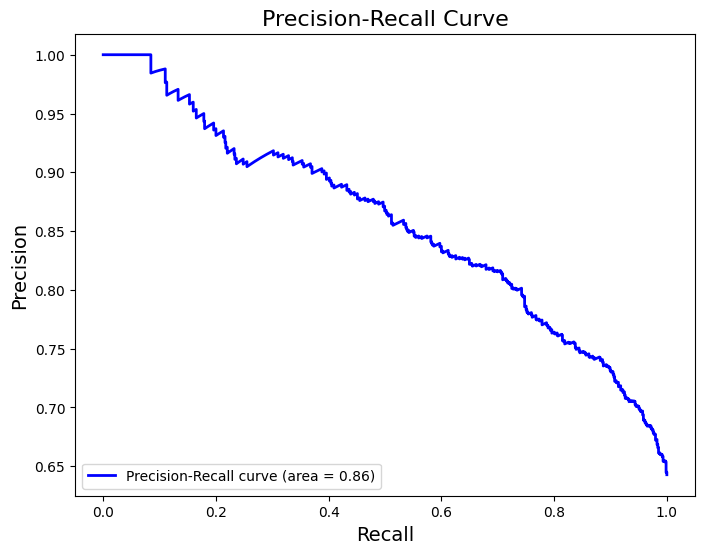

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test, scores)
average_precision = average_precision_score(y_test, scores)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {average_precision:0.2f})')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc="lower left")
plt.show()

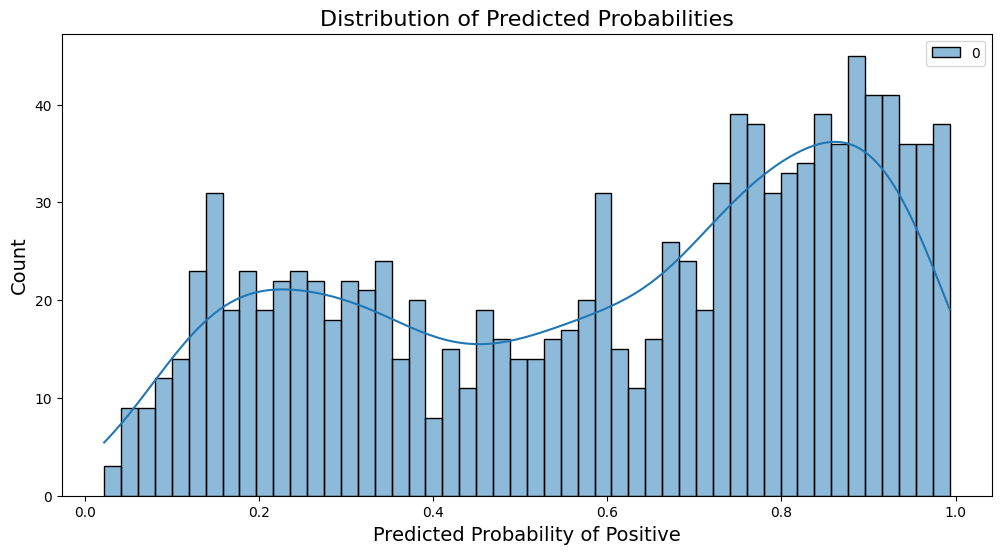

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(scores, bins=50, color='purple', kde=True)
plt.title('Distribution of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability of Positive', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [ ]:

TRAIN_SIZE = 0.8
MAX_SEQUENCE_LENGTH = 30
new_text = [

    "Tech layoffs trigger recession fears"]

new_seq = tokenizer.texts_to_sequences(new_text)
new_seq_padded = pad_sequences(new_seq, maxlen=MAX_SEQUENCE_LENGTH)

prediction = model.predict(new_seq_padded)


label = "Positive" if prediction[0] > 0.5 else "Negative"
confidence = float(prediction[0])

print(f"📰 News: {new_text[0]}")
print(f"📊 Sentiment: {label} ({confidence:.2f} confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
📰 News: Tech layoffs trigger recession fears
📊 Sentiment: Negative (0.16 confidence)


<ipython-input-43-a7591f3741db>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0])
